##Import e style

In [ ]:
import torch, torchvision
from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from glob import glob
import shutil
from collections import defaultdict
import os
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

#Formattazione grafica
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

#HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

#sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
#####

RANDOM_SEED = 42   #Replicare l'esperimento
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

from google.colab import drive
drive.mount('/content/drive')
#drive.flush_and_unmount()#Rende visibili le modifiche

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


device(type='cpu')

## Importa dataset



In [ ]:
!rm -rf GTSRB
!rm -rf data
!rm -rd GTSRB_Final_Training_Images.zip

In [ ]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -qq GTSRB_Final_Training_Images.zip


--2022-07-14 18:11:29--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  29.4MB/s    in 9.8s    

2022-07-14 18:11:39 (26.8 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



### Exploration 


In [ ]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*')) #glob restituisce i path che corrispondono
print("Classi:")                                              #senza sorted altera ordine delle classi
len(train_folders)

Classi:


43


CSV funzioni visualizzazione immagini

In [ ]:
#Carica immagine
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)    #conversione BGR a RBG 

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

#Mostra immagine
def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

#Mostra griglia di immagini
def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Sample per ogni classe

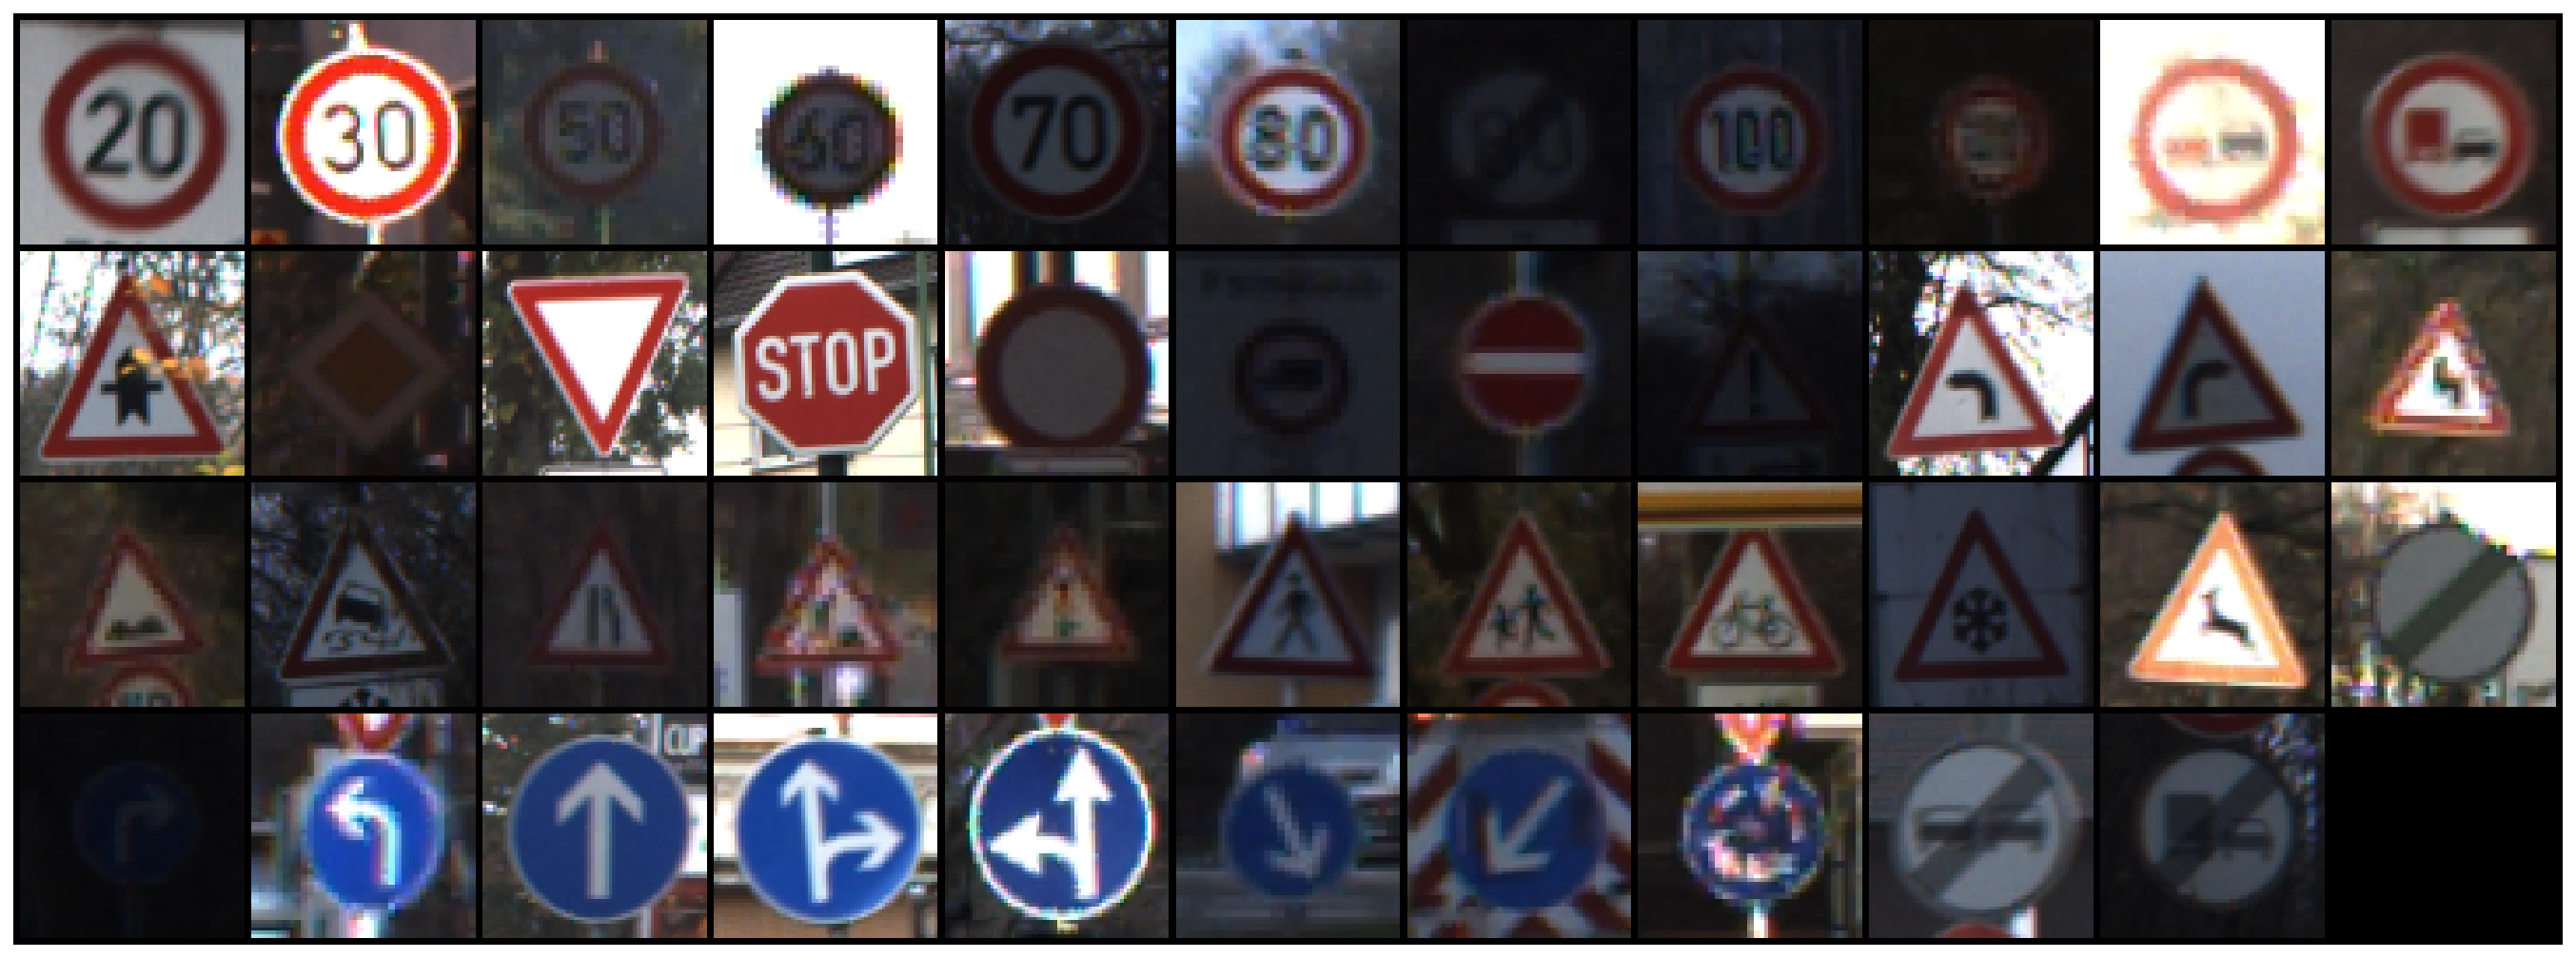

In [ ]:
sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]   #np.random.choice restituisce un elemento random dell'array
show_sign_grid(sample_images)                                                    #con f'{x}/*ppm' la stringa viene calcolara a runtime 

Singola immagine

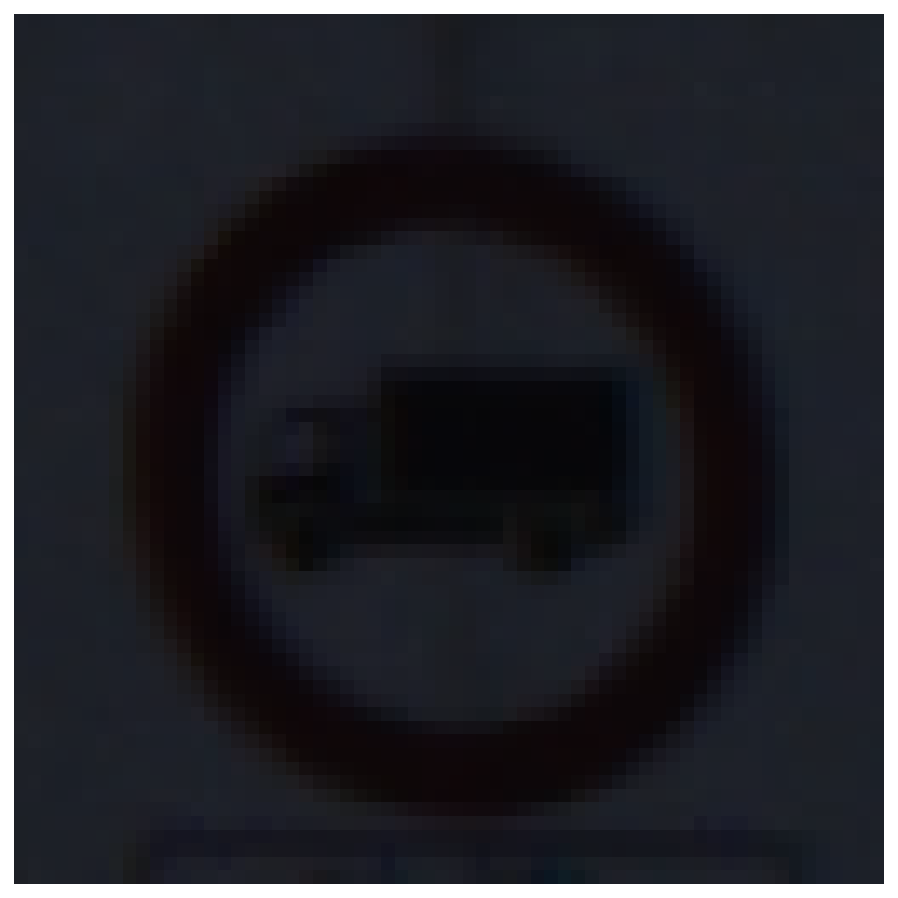

In [ ]:
img_path = glob(f'{train_folders[16]}/*ppm')[1]

show_image(img_path)

## Building dataset


In [ ]:
'''class_names = ['priority_road', 'give_way', 'stop', 'no_entry']
class_indices = [13, 14, 15, 18]
'''
class_names = ['00_Speed limit 20km', '01_Speed limit 30km', '02_Speed limit 50km', 
    '03_Speed limit 60km', '04_Speed limit 70km', '05_Speed limit 80km', 
    '06_End of speed limit 80km', '07_Speed limit 100km', 
    '08_Speed limit 120km', '09_No passing', 
    '10_No passing for vehicles over 3.5 metric tons', 
    '11_Right-of-way at the next intersection', '12_Priority road', '13_Yield (give_way)', 
    '14_Stop', '15_No vehicles', '16_Vehicles over 3.5 metric tons prohibited', 
    '17_No entry', '18_General caution', '19_Dangerous curve to the left', 
    '20_Dangerous curve to the right', '21_Double curve', '22_Bumpy road', 
    '23_Slippery road', '24_Road narrows on the right', '24_Road work', 
    '26_Traffic signals', '27_Pedestrians', '28_Children crossing', 
    '29_Bicycles crossing', '30_Beware of ice/snow', '31_Wild animals crossing', 
    '32_End of all speed and passing limits', '33_Turn right ahead', 
    '34_Turn left ahead', '35_Ahead only', '36_Go straight or right', 
    '37_Go straight or left', '38_Keep right', '39_Keep left', '40_Roundabout mandatory', 
    '41_End of no passing', '42_End of no passing by vehicles over 3.5 metric tons']    
'''

class_names = ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 
    'No passing for vehicles over 3.5 metric tons', 
    'Right-of-way at the next intersection', 'Priority road', 'Yield (give_way)', 
    'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve to the left', 
    'Dangerous curve to the right', 'Double curve', 'Bumpy road', 
    'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 
    'End of all speed and passing limits', 'Turn right ahead', 
    'Turn left ahead', 'Ahead only', 'Go straight or right', 
    'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 
    'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']
'''
class_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,
                 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
                 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
                 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
                 41, 42]


copia immagini nelle directory per ogni classe (semplifica torchvision's dataset helper)

In [ ]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']
#DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

**80% training, 10% validation, 10% test per ogni classe** (Nella corrispettiva cartella)

In [ ]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
    #image_paths, indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')   # Copy the content of source to destination

00_Speed limit 20km: 210
01_Speed limit 30km: 2220
02_Speed limit 50km: 2250
03_Speed limit 60km: 1410
04_Speed limit 70km: 1980
05_Speed limit 80km: 1860
06_End of speed limit 80km: 420
07_Speed limit 100km: 1440
08_Speed limit 120km: 1410
09_No passing: 1470
10_No passing for vehicles over 3.5 metric tons: 2010
11_Right-of-way at the next intersection: 1320
12_Priority road: 2100
13_Yield (give_way): 2160
14_Stop: 780
15_No vehicles: 630
16_Vehicles over 3.5 metric tons prohibited: 420
17_No entry: 1110
18_General caution: 1200
19_Dangerous curve to the left: 210
20_Dangerous curve to the right: 360
21_Double curve: 330
22_Bumpy road: 390
23_Slippery road: 510
24_Road narrows on the right: 270
24_Road work: 1500
26_Traffic signals: 600
27_Pedestrians: 240
28_Children crossing: 540
29_Bicycles crossing: 270
30_Beware of ice/snow: 450
31_Wild animals crossing: 780
32_End of all speed and passing limits: 240
33_Turn right ahead: 689
34_Turn left ahead: 420
35_Ahead only: 1200
36_Go stra

##Il dataset è sbilanciato, applico trasformazioni per **"Augmentation"**

In [ ]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomAffine(degrees=(-20, 20), translate=(0.1,0.3), scale=(0.7,1), shear=(-20, 20)),
  T.ColorJitter(brightness=0.7, contrast=0.3, saturation=0.4, hue=0), #modifica condizioni foto
  T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)), #blur
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Cereo dataset PyTorch per ogni "image dataset folder" e "data loaders" per semplificare training


In [ ]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Salvo numero di example e nome delle classi in ogni dataset

In [ ]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

print('########################################')
print(image_datasets['train'].classes)
print('########################################')

print(dataset_sizes)

{'test': 3921, 'train': 31367, 'val': 3921}



Visualizza immagini dopo trasformazioni (reverse della normalizzazione e dei canali colore)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


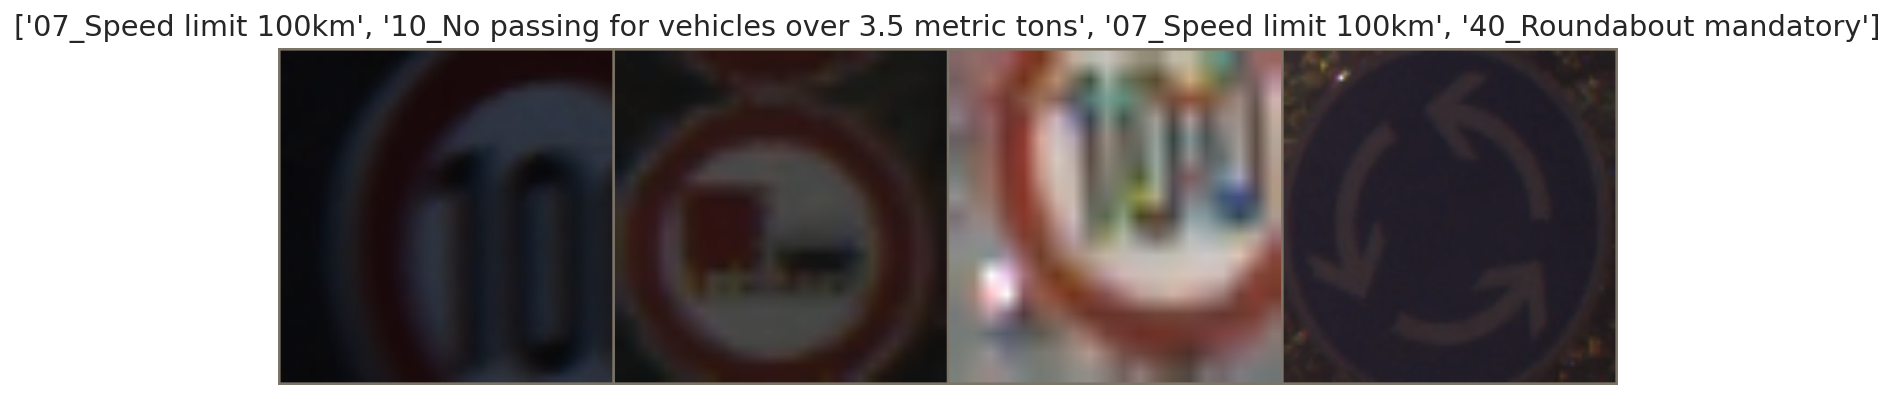

In [ ]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Creo Modello
(Più modelli in base all'input per confronto)

Il layer di output deve essere sostituito per combaciare con il numero di output ed essere addestrato

In [ ]:
def create_model(net_model, n_classes):

  if(net_model=='resnet18_no'):
    model = models.resnet18(pretrained = False, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='resnet18'):
    model = models.resnet18(pretrained = True, progress = True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if (net_model == 'alexnet'):
    model = models.alexnet(pretrained = True, progress = True)
    n_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(n_features,n_classes)

  if(net_model == 'googleLeNet'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
    n_features = model.fc.in_features
    model.fc = nn.Linear(n_features, n_classes)

  if(net_model=='mobilenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(model.last_channel, n_classes)

  if(net_model=='mobilenet_v3'):
    model = models.mobilenet_v3_small(pretrained=True, progress=True)
    model.classifier[-1] = nn.Linear(1024, n_classes)

  if(net_model == 'shufflenet_v2'):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)
    model.fc = nn.Linear(1024, n_classes)

  if(net_model == 'efficientnet_b0'):
    model = models.efficientnet_b0(pretrained=True, progress=True)
    model.classifier[1] = nn.Linear(in_features=1280, out_features=n_classes)

#  if(net_model == 'NASNet-A-Mobile'):
#    #model = timm.create_model('nasnetalarge', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
#    #nasnetamobile(num_classes=1000, pretrained='imagenet')
#    model = models.nasnetmobile(pretrained = True, progress=True)


    #model = models.mobilenet_v3_small(pretrained=True, progress=True)
    #print(model.classifier) 

  return model.to(device)

### Training
Modello in train-mode. Si cicla sugli input e le lora label, si ottiene la predizione (classe con max prob) e si calcola loss ed accuracy

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
  
  #Calcolo gradiente attivo
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()
  accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)

##Evaluating
Simile al training ma effettuato sul validation per verificare il modello e non calcola gradiente

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  #Calcolo gradiente inattivo
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())
      accuracy = correct_predictions.double() / n_examples

  return accuracy.cpu(), np.mean(losses)


##Training completo

L'History salva le performance, pytorch salva il "miglior modello" ed i suoi pesi ottenuti durante il training

In [ ]:
                                                                    #30
def train_model(model,net, data_loaders, dataset_sizes, device, n_epochs=10):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  if(net=='resnet18_no'):
    PATH1 = 'drive/MyDrive/Modelli/resnet18_no/resnet18_no.pt' 
    PATH2 = 'drive/MyDrive/Modelli/resnet18_no/resnet18_no_model.pt'  

  if(net=='resnet18'):
    PATH1 = 'drive/MyDrive/Modelli/resnet18/resnet18.pt'
    PATH2 = 'drive/MyDrive/Modelli/resnet18/resnet18_model.pt'

  if (net == 'alexnet'):
    PATH1 = 'drive/MyDrive/Modelli/alexnet/alexnet.pt'
    PATH2 = 'drive/MyDrive/Modelli/alexnet/alexnet_model.pt'

  if(net == 'googleLeNet'):
    PATH1 = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet.pt'
    PATH2 = 'drive/MyDrive/Modelli/googleLeNet/googleLeNet_model.pt'

  if(net=='mobilenet_v2'):
    PATH1 = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2.pt'
    PATH2 = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v2_model.pt'

  if(net=='mobilenet_v3'):
    PATH1 = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v3.pt'
    PATH2 = 'drive/MyDrive/Modelli/mobilenet_v2/mobilenet_v3_model.pt'

  if(net == 'shufflenet_v2'):
    PATH1 = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2.pt'
    PATH2 = 'drive/MyDrive/Modelli/shufflenet_v2/shufflenet_v2_model.pt'

  if(net == 'efficientnet_b0'):
    PATH1 = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0.pt'
    PATH2 = 'drive/MyDrive/Modelli/efficientnet_b0/efficientnet_b0_model.pt'

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss}  accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss}  accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      #Salvataggio
      #torch.save(model.state_dict(), 'drive/MyDrive/Modelli/resnet18/resnet18_no.bin')
      torch.save(model.state_dict(), PATH1)
      torch.save(model, PATH2)

      #CARICA INTERO MODELLO
      #model = torch.load(PATH2)
      #model.eval()
      
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  torch.save(model.state_dict(), PATH1)
  print("Model saved")

  
  return model, history

##Resnet18 no pretrain no augmentation

In [ ]:
%%time

base_model = create_model("resnet18_no",len(class_names))

base_model, history = train_model(base_model, 'resnet18_no', data_loaders, dataset_sizes, device)



Scelta e training del modello:

##ResNet18

In [ ]:
%%time
#comando time restituisce wall time della cella
base_model = create_model("resnet18",len(class_names))

base_model, history = train_model(base_model, 'resnet18', data_loaders, dataset_sizes, device)


##AlexNet

In [ ]:
%%time
base_model = create_model('alexnet', len(class_names))


base_model, history = train_model(base_model, 'alexnet', data_loaders, dataset_sizes, device)

##GoogleLeNet

In [ ]:
%%time
base_model = create_model('googleLeNet', len(class_names))


base_model, history = train_model(base_model, 'googleLeNet', data_loaders, dataset_sizes, device)

##MobileNet_v2

In [ ]:
%%time
base_model = create_model('mobilenet_v2', len(class_names))


base_model, history = train_model(base_model, 'mobilenet_v2', data_loaders, dataset_sizes, device)

##MobileNet_v3

In [ ]:
%%time
base_model = create_model('mobilenet_v3', len(class_names))

base_model, history = train_model(base_model, 'mobilenet_v3' , data_loaders, dataset_sizes, device)

##ShuffleNet_v2

In [ ]:
%%time
base_model = create_model('shufflenet_v2', len(class_names))


base_model, history = train_model(base_model, 'shufflenet_v2', data_loaders, dataset_sizes, device)

##EfficientNet_b0

In [ ]:
%%time
base_model = create_model('efficientnet_b0', len(class_names))

base_model, history = train_model(base_model, 'efficientnet_b0', data_loaders, dataset_sizes, device)

##Visualizzazione History

In [ ]:
def plot_training_history(history):
  #device = torch.device("cpu")
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], 'o-', label='train loss')
  ax1.plot(history['val_loss'], '^-', label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 3.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], 'o-', label='train accuracy')
  #print("Sono qui")
  ax2.plot(history['val_acc'], '^-', label='validation accuracy')
  
  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')
  fig.savefig('drive/MyDrive/Modelli/resnet18/resnet18_no_pretrain_no_augmentation.png')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
plot_training_history(history)


## Evaluation

Valutazione del modello sul TestSet. (No calcolo gradiente)

In [ ]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if

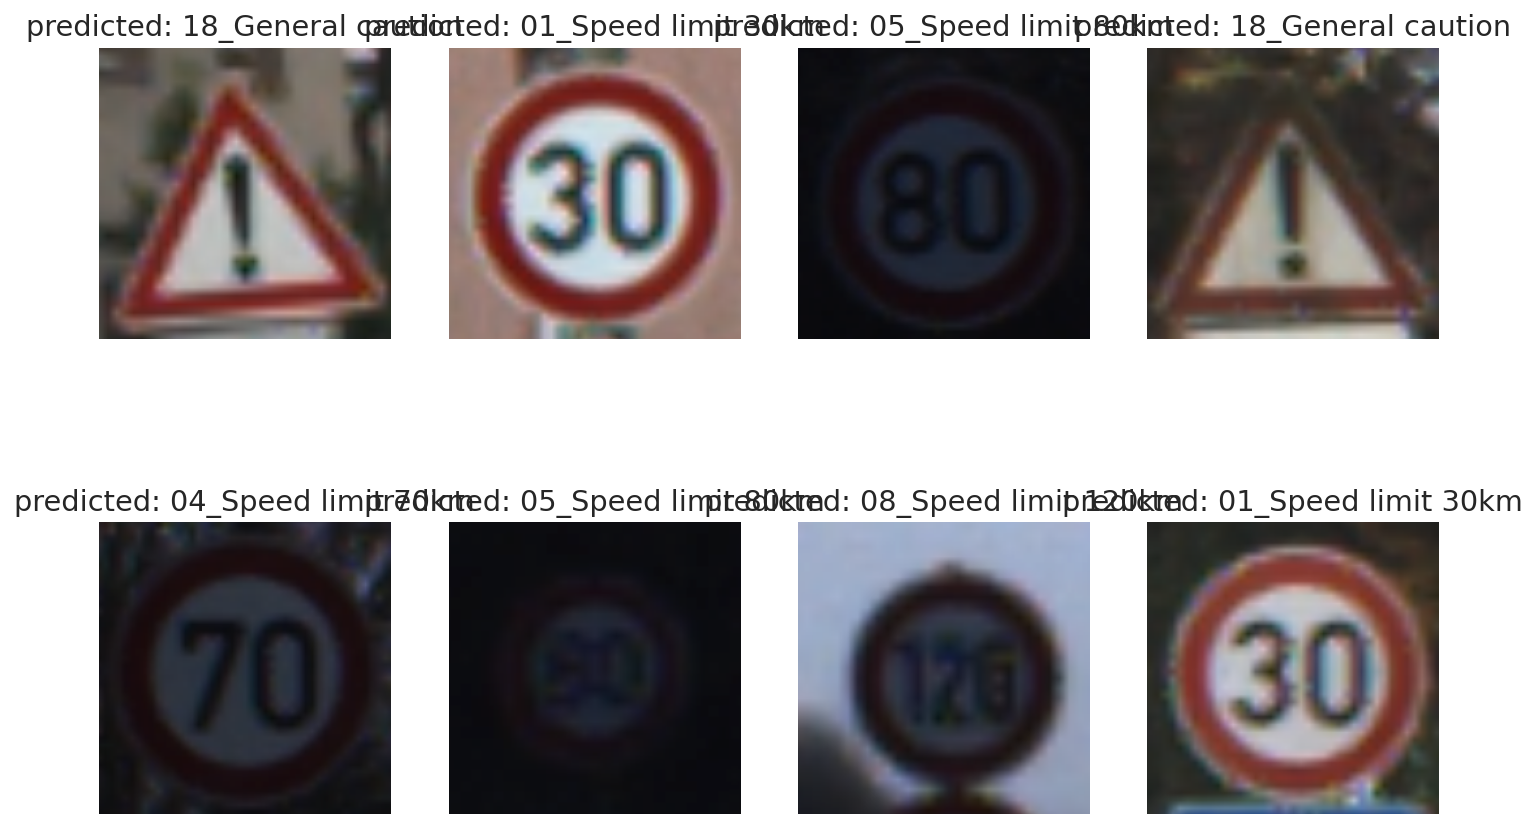

In [ ]:
base_model = create_model('resnet18', 43)

#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli_backup/resnet18_no/resnet18_no.pt', map_location = device))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18_strano.pt', map_location = device))

#base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/alexnet/alexnet_no_pretrain_no_augmentation.bin'))

      
show_predictions(base_model, class_names, n_images=8)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])
#print(y_pred, y_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))
print("Accuracy:",accuracy_score(y_test, y_pred, normalize=True, sample_weight=None))
print()
'''def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

print("Accuracy: .3f", )
from sklearn.metrics import accuracy_score
print('Test accuracy: ',accuracy_score(labels, classes_x)*100)'''

##Confusion Matrix
Visualizzazione più significativa rispetto all'accuracy delle performance 

In [ ]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  #plt.figure(figsize = (10,7))
  #plt.figure(figsize=(60, 40), dpi=90)
  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues", annot_kws={'fontsize':5})
  #hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');


cm = confusion_matrix(y_test, y_pred)

show_confusion_matrix(cm, class_names)
  

##TEST e FPS

In [ ]:
import numpy as np
import cv2
import torch
import os
import time
import argparse
import pathlib
import PIL
from PIL import Image
from tqdm import tqdm
#import custom_utils


!rm -rd GTSRB_Final_Test_Images.zip
!rm -rd GTSRB_Final_Test_GT.zip
!rm -rf GTSRB/Final_Test
!rm -rf GT-final_test.csv
!rm -rf GTSRB/Readme-Images-Final-test.txt
!rm -rf GTSRB/Readme-Images.txt

!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip
!unzip -qq GTSRB_Final_Test_Images.zip
!unzip -qq GTSRB_Final_Test_GT.zip

base_model = create_model("resnet18",len(class_names))
base_model.load_state_dict(torch.load('drive/MyDrive/Modelli/resnet18/resnet18_strano.pt', map_location = device))     
base_model.eval()

# DataFrame for ground truth.
gt_df = pd.read_csv('GT-final_test.csv', delimiter=';' )
gt_df = gt_df.set_index('Filename', drop=True)

predictions = []
ground_truth = []

counter = 0


correct_count = 0
frame_count = 0 # To count total frames.
total_fps = 0 # To get the final frames per second. 
test_images = 0

for filename in tqdm(os.scandir('GTSRB/Final_Test/Images')):
  if filename.is_file():
    #print(filename.path) 
    if(filename.path == 'GTSRB/Final_Test/Images/GT-final_test.test.csv'):
      continue
    test_images+=1
 
    #if(test_images==1000):
    #  break

    img = Image.open(filename.path)
    img = img.convert('RGB')

    img = transforms['test'](img).unsqueeze(0)

    start_time = time.time()
    pred = base_model(img.to(device)) 
    end_time = time.time()
    # Get the softmax probabilities.
    pred = F.softmax(pred, dim=1)#probs = F.softmax(outputs).data.squeeze()

    _, class_idx = torch.max(pred,1)
    #class_idx = convert(class_idx.item())

    # Get the ground truth.
    image_name = filename.path.split(os.path.sep)[-1]
    gt_idx = gt_df.loc[image_name].ClassId

    if gt_idx == class_idx:
      correct_count += 1
    else:
      print('Sbagliato:')
      print('Image_path:',filename.path, 'prediction:',class_idx,'ground_truth:',gt_idx)
      print()
      print()
    predictions.append(class_idx)
    ground_truth.append(gt_idx)
    #predictions.extends(class_idx)
    #ground_truth.extends(gt_idx)       
    #predictions = torch.as_tensor(predictions).cpu()
    #ground_truth = torch.as_tensor(ground_truth).cpu() 
    fps = 1 / (end_time - start_time)
    total_fps += fps
    frame_count += 1
  
print(f"Total number of test images: {test_images}")
print(f"Total correct predictions: {correct_count}")
print(f"Accuracy: {correct_count/test_images*100:.3f}")

# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")



##Altre Metriche

In [ ]:
print(classification_report(predictions, ground_truth, target_names=class_names))
print("Accuracy:",accuracy_score(ground_truth, ground_truth, normalize=True, sample_weight=None))
print()

## Classificazione immagine non vista


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr
To: /content/stop-sign.jpg
100% 77.3k/77.3k [00:00<00:00, 34.3MB/s]


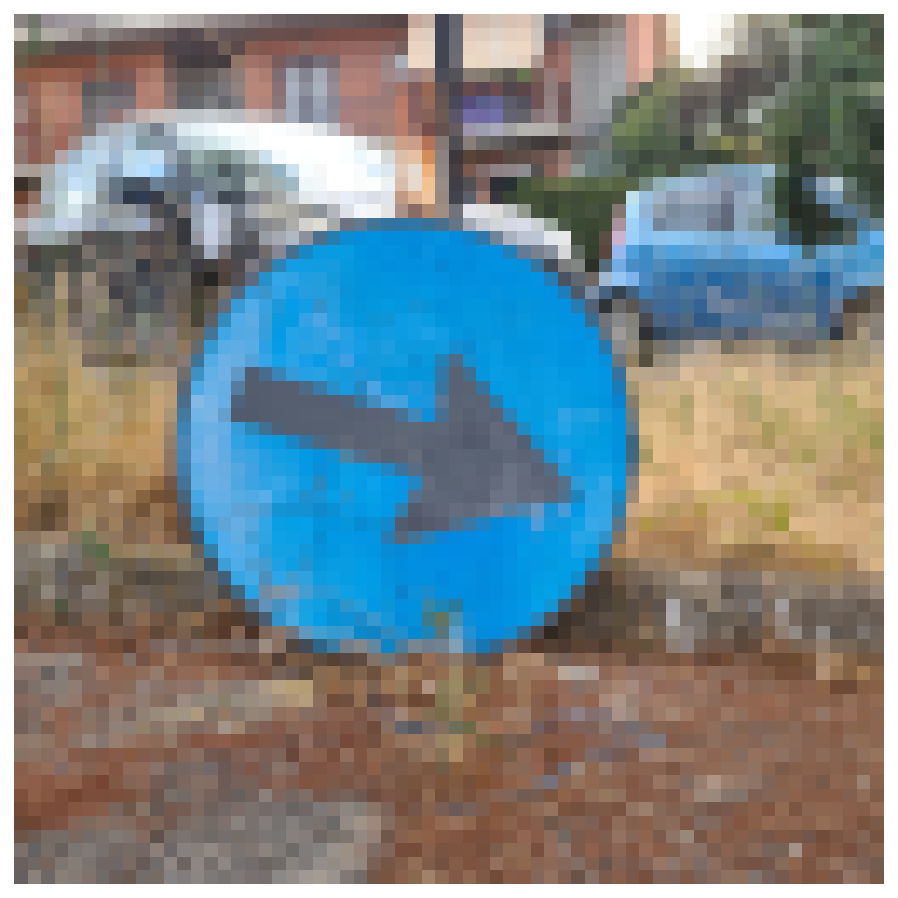

In [ ]:
!gdown --id 19Qz3a61Ou_QSHsLeTznx8LtDBu4tbqHr


#img_path = 'stop-sign.jpg' #stop
#img_path = 'drive/MyDrive/inference/IMG_20220710_195852_099.jpg' #speed_limit 30
#img_path = 'drive/MyDrive/inference/20220710_200527.jpg'  #round_about_mandatory
#img_path = 'drive/MyDrive/inference/IMG_20220710_193242_762.jpg' #no_entry
#img_path = 'drive/MyDrive/inference/IMG_20220710_195854_666.jpg'
#img_path = 'drive/MyDrive/inference/20220710_191336.jpg'  #keep right
img_path = 'drive/MyDrive/inference/20220710_191319.jpg'
show_image(img_path)


Predizione con confidenza rispetto a tutte le classi possibili

In [ ]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [ ]:
#pred = predict_proba(base_model, 'stop-sign.jpg')
pred = predict_proba(base_model, img_path)
pred

array([1.02791994e-07, 1.84524595e-07, 8.30855029e-08, 2.42601573e-07,
       5.00693261e-07, 9.11836764e-07, 1.03073717e-07, 4.45223037e-07,
       1.50196087e-07, 3.25530636e-05, 6.32864703e-06, 3.93107740e-07,
       1.74788124e-06, 5.33330740e-06, 4.63390734e-07, 2.30970315e-07,
       1.79407095e-06, 1.85728859e-05, 3.00432021e-06, 3.57249860e-06,
       6.55591475e-06, 8.70964868e-07, 2.43951860e-07, 5.11356302e-06,
       4.33208953e-07, 2.09997529e-06, 1.07089750e-06, 4.38132446e-07,
       4.84315521e-08, 5.53339952e-08, 1.70716032e-06, 2.03105537e-06,
       7.50061417e-07, 2.46302574e-03, 2.99752634e-02, 2.45436393e-02,
       1.63232908e-04, 3.32893163e-04, 6.92253530e-01, 2.49335602e-01,
       8.31193465e-04, 3.32256900e-06, 9.96683767e-08], dtype=float32)

Plot confidenza

In [ ]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

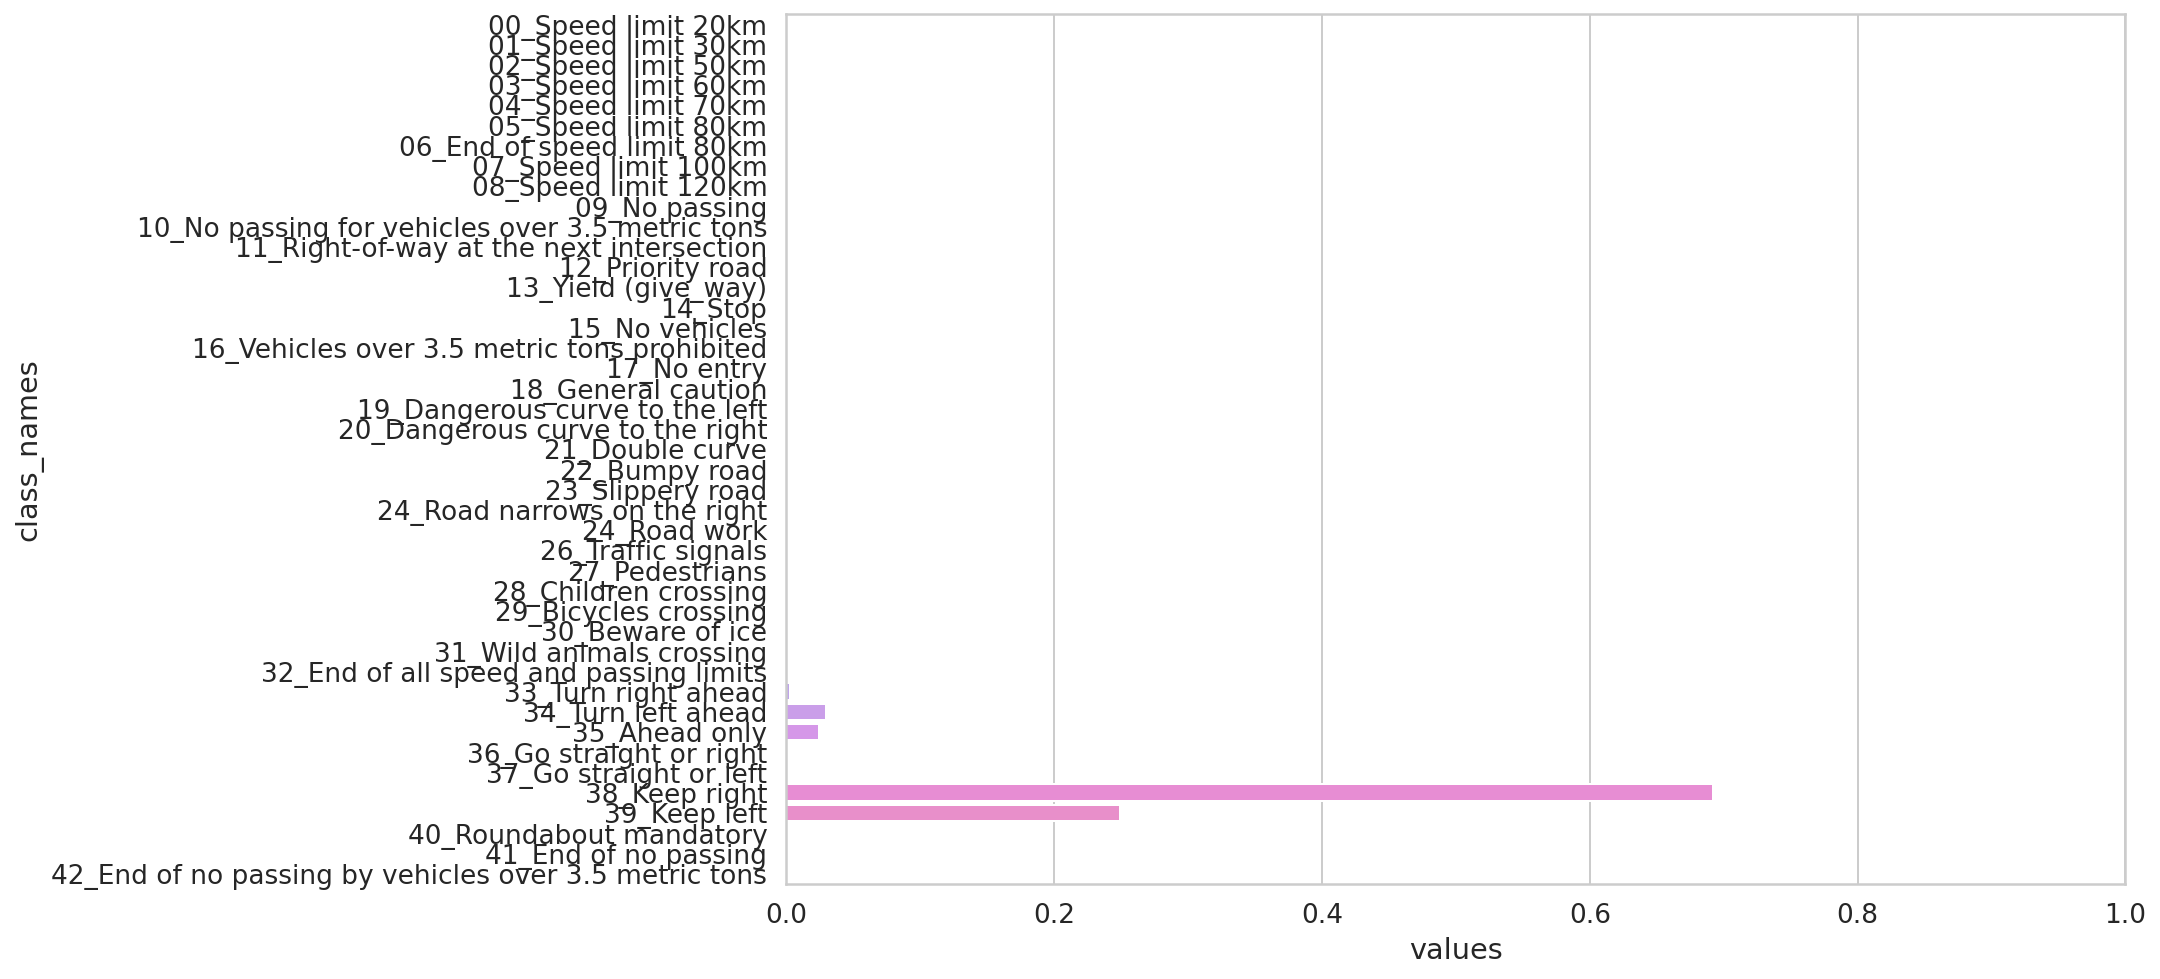

In [ ]:
show_prediction_confidence(pred, class_names)